In [29]:
!pip install torch torchvision

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt
import copy

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loader = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

In [32]:
def gram_matrix(input):
    a, b, c, d = input.size()
    features = input.view(a * b, c * d)
    G = torch.mm(features, features.t())
    return G.div(a * b * c * d)

class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
    def forward(self, input):
        self.loss = nn.functional.mse_loss(input, self.target)
        return input

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()
    def forward(self, input):
        G = gram_matrix(input)
        self.loss = nn.functional.mse_loss(G, self.target)
        return input

VGG19 Model with Losses

In [33]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = mean.clone().view(-1, 1, 1)
        self.std = std.clone().view(-1, 1, 1)
    def forward(self, img):
        return (img - self.mean) / self.std

def get_style_model_and_losses(cnn, normalization_mean, normalization_std, style_img, content_img,
                                content_layers=['conv_4'], style_layers=['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']):
    cnn = copy.deepcopy(cnn)
    normalization = Normalization(normalization_mean, normalization_std).to(device)
    content_losses = []
    style_losses = []
    model = nn.Sequential(normalization)
    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            continue
        model.add_module(name, layer)
        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)
        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    model = model[:i + 1]
    return model, style_losses, content_losses

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Style Transfer Execution

In [34]:
def run_style_transfer(cnn, norm_mean, norm_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    model, style_losses, content_losses = get_style_model_and_losses(
        cnn, norm_mean, norm_std, style_img, content_img)
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    run = [0]
    while run[0] <= num_steps:
        def closure():
            input_img.data.clamp_(0, 1)
            optimizer.zero_grad()
            model(input_img)
            style_score = sum(sl.loss for sl in style_losses)
            content_score = sum(cl.loss for cl in content_losses)
            loss = style_weight * style_score + content_weight * content_score
            loss.backward()
            run[0] += 1
            return loss
        optimizer.step(closure)
    input_img.data.clamp_(0, 1)
    return input_img

Load, Transfer, Display

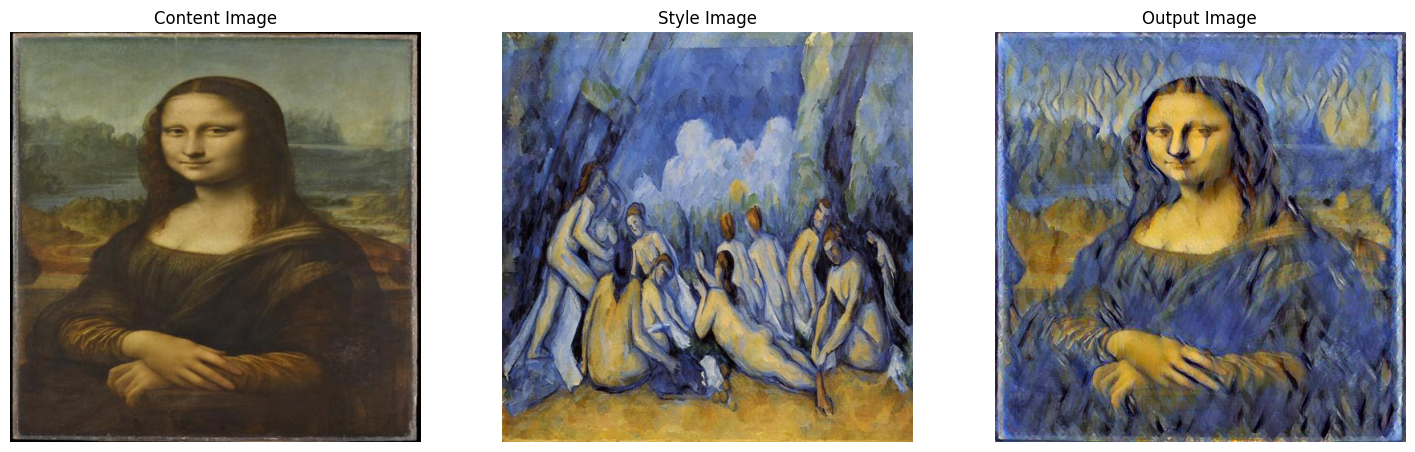

In [35]:
# Upload your images to Colab and give the correct path
content_img = image_loader("/content/Mona Lisa.JPG")
style_img = image_loader("/content/Large Bathers.jpg")
input_img = content_img.clone()

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

# Display
def im_convert(tensor):
    image = tensor.cpu().clone().detach()
    image = image.squeeze(0)
    image = transforms.ToPILImage()(image)
    return image

plt.figure(figsize=(18,6))
plt.subplot(1, 3, 1)
plt.imshow(im_convert(content_img))
plt.title('Content Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(im_convert(style_img))
plt.title('Style Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(im_convert(output))
plt.title('Output Image')
plt.axis('off')
plt.show()

In [36]:
im_convert(output).save("output_stylized.png")

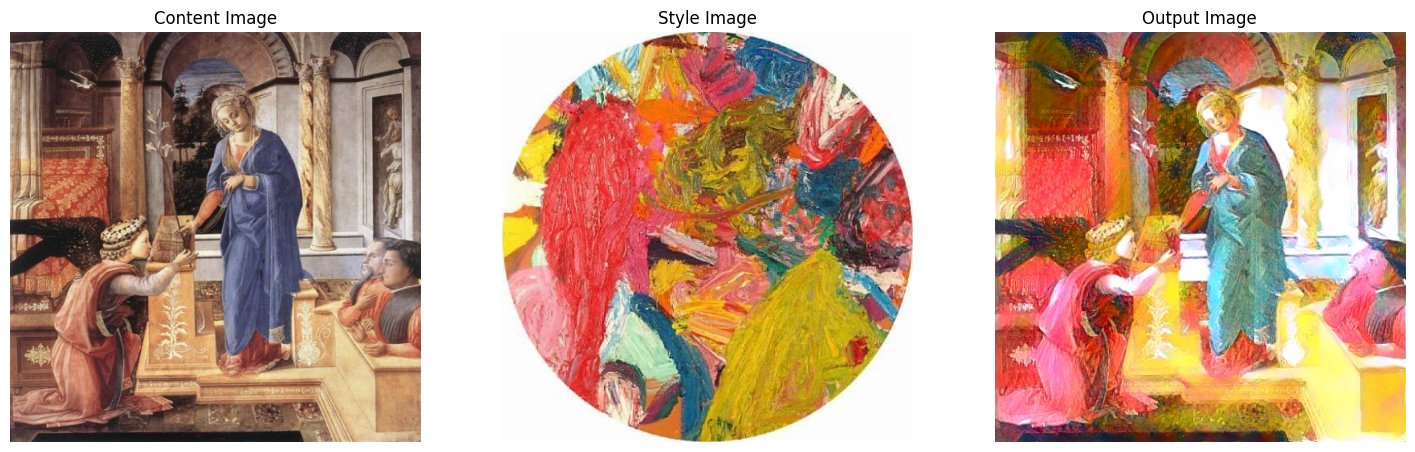

In [39]:
content_img = image_loader("/content/The Annunciation with two Kneeling Donors.jpg")
style_img = image_loader("/content/tadwalis-island.jpg")
input_img = content_img.clone()
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)
plt.figure(figsize=(18,6))
plt.subplot(1, 3, 1)
plt.imshow(im_convert(content_img))
plt.title('Content Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(im_convert(style_img))
plt.title('Style Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(im_convert(output))
plt.title('Output Image')
plt.axis('off')
plt.show()

In [40]:
im_convert(output).save("output_tadwalis-island.png")

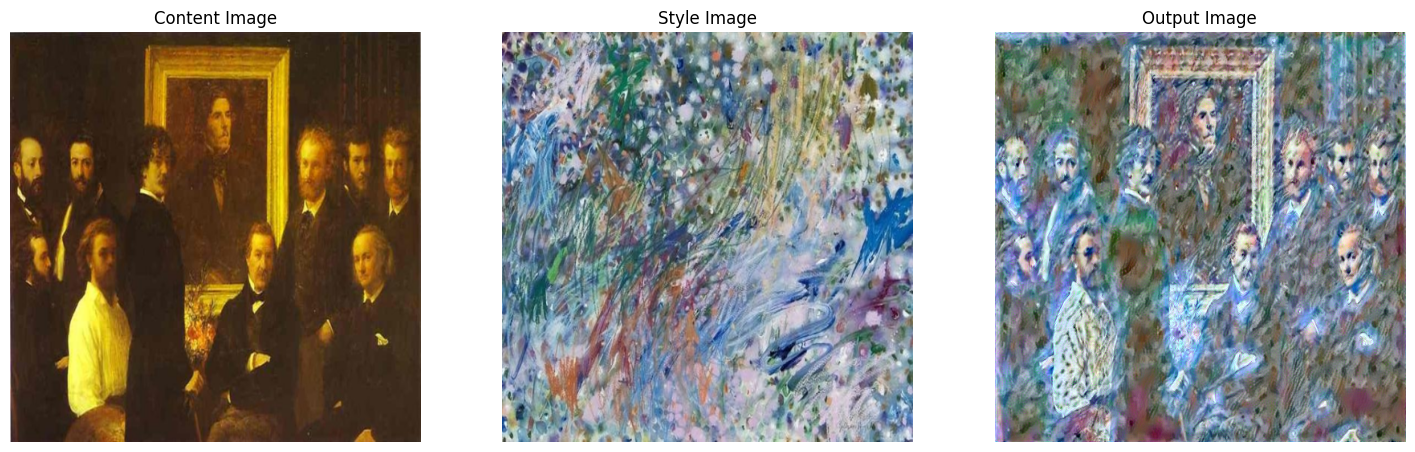

In [41]:
content_img = image_loader("/content/homage-to-delacroix.jpg")
style_img = image_loader("/content/abstract-composition-1972.jpg")
input_img = content_img.clone()
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)
plt.figure(figsize=(18,6))
plt.subplot(1, 3, 1)
plt.imshow(im_convert(content_img))
plt.title('Content Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(im_convert(style_img))
plt.title('Style Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(im_convert(output))
plt.title('Output Image')
plt.axis('off')
plt.show()

In [42]:
im_convert(output).save("output_abstract-composition.png")